<a href="https://colab.research.google.com/github/ShrutiRajput1234/NNDL_Lab/blob/main/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [40]:
df = pd.read_csv('/content/monthly-milk-production.csv',index_col='Month',parse_dates=True) #Date is not  string
df.index.freq='MS'   #monthly

In [41]:
df.head()     #month wise production data will be displayed

,Milk Production
Month,
1962-01-01 01:00:00,589.0
1962-02-01 01:00:00,561.0
1962-03-01 01:00:00,640.0
1962-04-01 01:00:00,656.0
1962-05-01 01:00:00,727.0


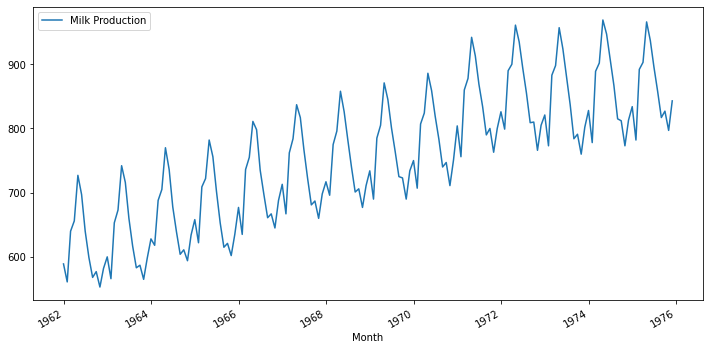

In [42]:
df.plot(figsize=(12,6))

In [43]:
from statsmodels.tsa.seasonal import seasonal_decompose

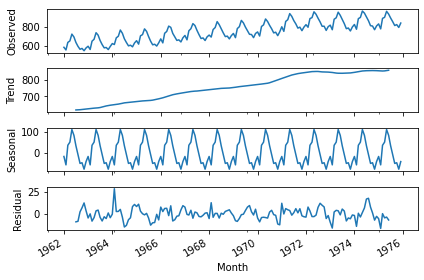

In [46]:
results =seasonal_decompose(df['Milk Production'])
results.plot();

In [47]:
len(df)

168

In [48]:
train = df.iloc[:156]        # all data except the last 12 months data 168-12=156
test = df.iloc[156:]         # Last 12 months data

In [51]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [52]:
df.head(),df.tail()       #magnitude of the production values not in proper range

(                     Milk Production
 Month                               
 1962-01-01 01:00:00            589.0
 1962-02-01 01:00:00            561.0
 1962-03-01 01:00:00            640.0
 1962-04-01 01:00:00            656.0
 1962-05-01 01:00:00            727.0,                      Milk Production
 Month                               
 1975-08-01 01:00:00            858.0
 1975-09-01 01:00:00            817.0
 1975-10-01 01:00:00            827.0
 1975-11-01 01:00:00            797.0
 1975-12-01 01:00:00            843.0)

In [53]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [54]:
scaled_train[:10]    # transform method covert the values in the 0...1.

array([[0.08653846],
       [0.01923077],
       [0.20913462],
       [0.24759615],
       [0.41826923],
       [0.34615385],
       [0.20913462],
       [0.11057692],
       [0.03605769],
       [0.05769231]])

In [55]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [56]:
# define generator
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

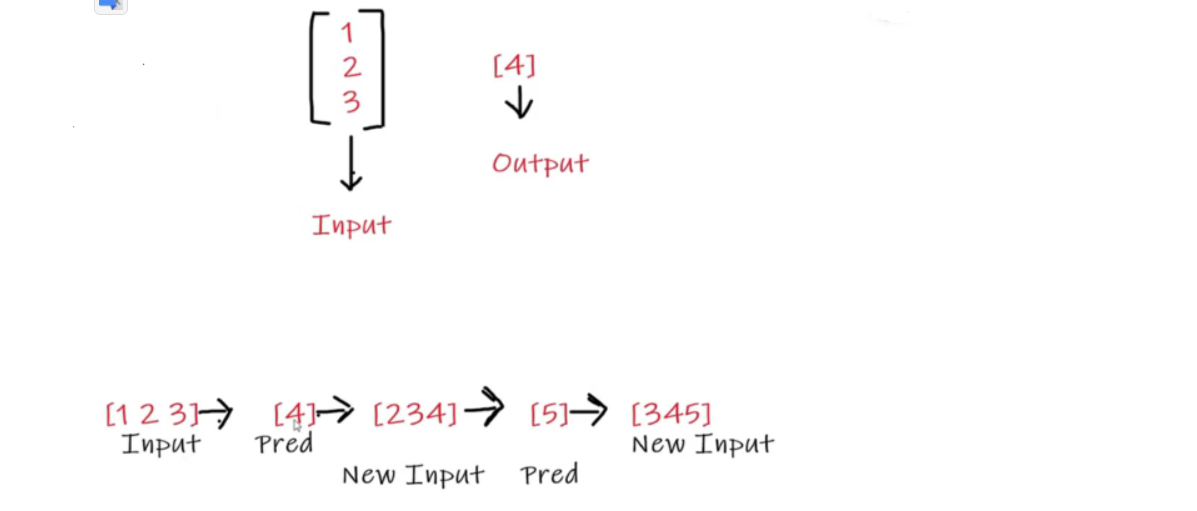

In [57]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.08653846 0.01923077 0.20913462]
Predict this y: 
 [[0.24759615]]


In [58]:
X.shape        # 1 row 3 columns and 1 feature

(1, 3, 1)

In [59]:
# We do the same thing, but now instead for 12 months
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [60]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [61]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [62]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [63]:
# fit model
model.fit(generator,epochs=50)  #generator creates batches of 3-3 inputs and using that predict the next value

Epoch 1/50
144/144 [==============================] - 4s 6ms/step - loss: 0.0366
Epoch 2/50
144/144 [==============================] - 1s 6ms/step - loss: 0.0218
Epoch 3/50
144/144 [==============================] - 1s 6ms/step - loss: 0.0162
Epoch 4/50
144/144 [==============================] - 1s 6ms/step - loss: 0.0128
Epoch 5/50
144/144 [==============================] - 1s 6ms/step - loss: 0.0093
Epoch 6/50
144/144 [==============================] - 1s 6ms/step - loss: 0.0092
Epoch 7/50
144/144 [==============================] - 1s 6ms/step - loss: 0.0049
Epoch 8/50
144/144 [==============================] - 1s 6ms/step - loss: 0.0055
Epoch 9/50
144/144 [==============================] - 1s 6ms/step - loss: 0.0041
Epoch 10/50
144/144 [==============================] - 1s 6ms/step - loss: 0.0062
Epoch 11/50
144/144 [==============================] - 1s 6ms/step - loss: 0.0042
Epoch 12/50
144/144 [==============================] - 1s 6ms/step - loss: 0.0044
Epoch 13/50
144/144 [====

In [64]:
last_train_batch = scaled_train[-12:] #taking last 12 months values in training set to make prediction for 1st value in test set                                                             

In [65]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [66]:
model.predict(last_train_batch)

array([[0.64734846]], dtype=float32)

In [67]:
scaled_test[0]      # original value was 0.67 model predicted it to be 0.65

array([0.67548077])

In [68]:
test_predictions = []     #empty list of test predictions

first_eval_batch = scaled_train[-n_input:]      #last 12 values from the training set
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [69]:
test_predictions

[array([0.64734846], dtype=float32),
 array([0.62199914], dtype=float32),
 array([0.8032866], dtype=float32),
 array([0.866233], dtype=float32),
 array([0.96318996], dtype=float32),
 array([0.9505338], dtype=float32),
 array([0.8880541], dtype=float32),
 array([0.7939166], dtype=float32),
 array([0.67425776], dtype=float32),
 array([0.626749], dtype=float32),
 array([0.56791127], dtype=float32),
 array([0.6098272], dtype=float32)]

In [70]:
test.head()

,Milk Production
Month,
1975-01-01 01:00:00,834.0
1975-02-01 01:00:00,782.0
1975-03-01 01:00:00,892.0
1975-04-01 01:00:00,903.0
1975-05-01 01:00:00,966.0


In [71]:
true_predictions = scaler.inverse_transform(test_predictions)

In [72]:
test['Predictions'] = true_predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


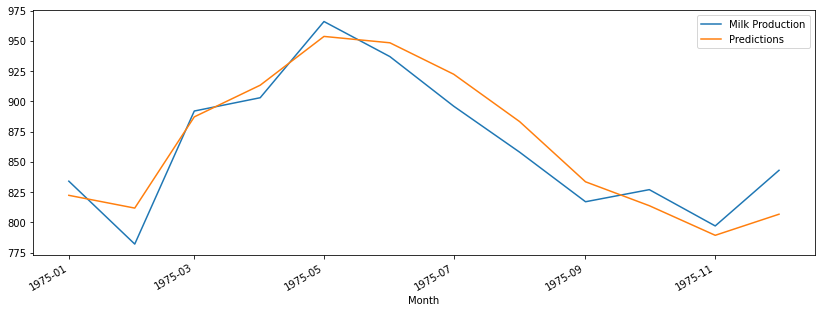

In [73]:
test.plot(figsize=(14,5))

In [75]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Milk Production'],test['Predictions']))
print(rmse)

19.575829878712252
